<p style="color:#050166; text-align:center; font-size:36px; font-weight:bold;">
Session #4- Computer vision with Deep Learning
</p>

    

<p style="color:#6ABCF9; text-align:center; font-size:36px; font-weight:bold;">
Advanced AI
</p>

<p style="text-align:center;">
  <img src="Captura de pantalla 2025-08-27 a las 21.22.58.png" alt="my image" width="120" height="80">
</p>

***<p style="text-align: center;">Prof. Beatriz Blanc</p>***
***<p style="text-align: center;">bblanc@faculty.ie.edu</p>***

***

### This session covers:

1. What is computer vision?
2. Computer vision applications
3. Image classification
    1. CNNs architecture
    2. Build our own image classifier
    3. Pre-trained models


***

### 3.C. Pre-trained models

In this notebook we are going to use some pre-trained models to classify different datasets of images.

In practice, very few people train an entire CNN from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a CNN on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

The three major **transfer learning** scenarios look as follows:

**CNN as fixed feature extractor**. Take a CNN pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the CNN as a fixed feature extractor for the new dataset. <br>
**Fine-tuning the CNN**. The second strategy is to not only replace and retrain the classifier on top of the CNN on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the CNN, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a CNN contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the CNN becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.<br>
**Pretrained models**. Since modern CNNs take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final CNN checkpoints for the benefit of others who can use the networks for fine-tuning. For example, the Caffe library has a Model Zoo where people share their network weights.


<small> Source: CS231n Deep Learning for Computer Vision

***

### Classification of ants and bees

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

#### Import libraries

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

As we normally do, to speed up the training process we'll try to run everythin in the GPU (if available)

In [40]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal GPU
elif torch.cuda.is_available():
    device = torch.device("cuda") # NVIDIA GPU (not typical on Mac)
    print('cuda')
else:
    device = torch.device("cpu")

cuda


So, we have our data, we have our libraries imported and our ``device``set.

We are going to be using a **ResNet** implementation. This means we are going to benefit from a model that has already been trained.

As a **rule of thumb for any pretrained model**:
1. Check the model’s documentation for input size, normalization mean/std.: e.g., torchvision.models.alexnet → 224×224, ImageNet mean/std.
2. Resize/crop your images to match the requirements
3. Normalize with the same mean/std used for pretraining.
4. Use data augmentation for training, but not for validation/testing.

We are going to use ``ResNet18``

Go to the documentation page [here](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)

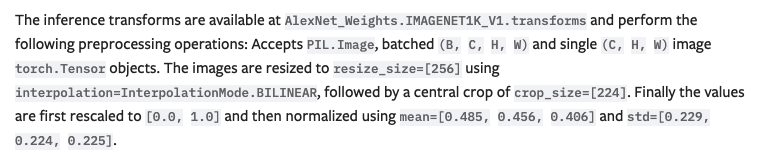

- We need to resize the image to 256. We can use ``Resize(256)`` 
- We need to crop the images to 224. We can use ``CenterCrop(224)`` or combine with cropping with ``RandomResizedCrop(224)`` (this would cover the data augmentation part)
- Normalize the values using ``Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])``

#### Data loading and transformations

In [ ]:
# we define the necessary transformations to be able to use the pre-trained CNN
data_transforms = {'train': transforms.Compose([
                            transforms.RandomResizedCrop(224), # for data augmentation
                            transforms.RandomHorizontalFlip(), # for data augmentation
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([
                       transforms.Resize(256),
                       transforms.CenterCrop(224),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),}

In [42]:
path_folder = 'hymenoptera_data'

train_dataset = datasets.ImageFolder(root=os.path.join(path_folder, "train"),
                                     transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(root=os.path.join(path_folder, "val"),
                                     transform=data_transforms['val'])

batch_size = 4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [43]:
train_size = len(train_dataset)
val_size = len(val_dataset)

dataset_sizes = {'train: ': train_size, 'val: ': val_size}
class_names = train_dataset.classes

# torchvision.models.resnet18()

print(f'Using {device} Device')

Using cuda Device


In [44]:
def imshow(img, title=None):
    img = img.numpy().transpose((1,2,0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    images, labels = next(iter(train_loader))
    
    imshow(torchvision.utils.make_grid(images), title=[class_names[x] for x in labels])

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    since = time.time() # for time record purposes
    
    # we create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path) # save initial weights
        best_acc = 0.0 # set to keep track of the best validation accuracy

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}') # for progress record purposes
            print('-' * 10)

            # each epoch will have a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode - here backpropagation happens
                    dataloader = train_loader
                else:
                    model.eval()   # Set model to evaluate mode - the model is only evaluated, no learning
                    dataloader = val_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data - same as we always do
                for inputs, labels in dataloader:
                    # move data to GPU
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients before starting backpropagation
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics: Track the total loss and number of correct predictions for the entire epoch
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step() # adjust learning rate at the end of each epoch

                # we calculate the average loss and accuracy over the whole dataset
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # if we have the best validation so far, save the model's weights
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()
        # summary of kpis and records
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [46]:
def visualize_model(model, num_images=6):
    # to store the current state of the model so we can restore it later
    was_training = model.training
    # change to evaluation mode
    model.eval()
    images_so_far = 0 # to keep track of the images we have plotted so far
    fig = plt.figure()

    with torch.no_grad(): # as we are not training 
        for i, (inputs, labels) in enumerate(val_loader):
            # same approach as always
            # data to gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # extract the predicted class (score and value)

            # we starting looping over the images
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images: # stop when we reach to the desired number of images and restore model state
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training) # to make sure the state is always restored

In [47]:
# load the model with the pretrained weights
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# model_ft.fc is the final layer of the network
num_ftrs = model_ft.fc.in_features
# we need to replace this layer with the number of classes in our dataset

In [48]:
# We replace that layer with one valid for our target (the one used to train resnet is imagenet 1000 classes)
model_ft.fc = nn.Linear(num_ftrs, 2) # this one will now output 2 classes: bees or ants
# we could also generalize it using len(class_names))

model_ft = model_ft.to(device) # as usual move the model to the gpu

# define the loss function - again, as we are doing classification we'll use the cross entropy loss
criterion = nn.CrossEntropyLoss()

# and the optimizer. in this case a SGD - feel free to try other optimizers
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # we will optimize all parameters (so all the layers) with an initial lr of 0.001 

# this scheduler reduces the lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=24)

Epoch 0/23
----------


KeyError: 'train'

In [ ]:
visualize_model(model_ft)